<img src="https://i.pinimg.com/originals/3a/40/f9/3a40f906233af4665ddce02948013da5.gif" alt="Air traffic gif"></img>

# Intersections of Great Circles

---

## Overview
A great circle path crosses the entire planet and as a result, any two (valid) great circle paths will always intersect at exactly two points around the globe.

In this notebook, we will:

1. Find the intersection of two great circle paths 

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy/) | Necessary | Used to work with large arrays |
| [Pandas](https://foundations.projectpythia.org/core/pandas) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy) | Helpful | Will be used for adding maps to plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib/) | Helpful | Will be used for plotting |

- **Time to learn**: 40 minutes

---

## Imports

- Import Packages
- Setup location dataframe with coordinates

In [3]:
import pandas as pd       # reading in data for location information from text file
import numpy as np        # working with arrays, vectors, cross/dot products, and radians

from pyproj import Geod   # working with the Earth as an ellipsod (WGS-84)
import geopy.distance     # working with the Earth as an ellipsod

import matplotlib.pyplot as plt                        # plotting a graph
from cartopy import crs as ccrs, feature as cfeature   # plotting a world map

In [4]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
0,arecibo,18.3441,-66.7527,0.374643,-0.872119,0.314723,1.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
1,boulder,40.0150,-105.2705,-0.201714,-0.738835,0.642988,1.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
2,boston,42.3601,-71.0589,0.239852,-0.698914,0.673788,1.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
3,redwoods,41.4017,-124.0417,-0.419898,-0.621549,0.661334,1.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
4,houston,29.5518,-95.0982,-0.077303,-0.866469,0.493210,1.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


In [5]:
location_df.index = location_df["name"]

## Find the intersection of two great circle paths

The intersection of two great circle paths always exists at two positions on the globe.

### Math of intersection

We can determine the intersections of two great circle paths as a the normal of two planes containing the great circles. Where the two planes intersect will represent the intersections on the surface of the globe.

First, we find the cross product of the vectors for the position's cartesian coordinates. Then, we find the cross product of the two normal planes. This will result in two intersection points, one for each side of the planet.

- [See more: Intersecting Radials](edwilliams.org/avform147.htm#Intersection)

In [6]:
def intersection_of_gc(start_gc1=None, end_gc1=None,
                      start_gc2=None, end_gc2=None):
    # determine the normal of planes containing great circles

    # cross product of vectors
    normal_one = np.cross([location_df.loc[start_gc1, "cart_x"],
                           location_df.loc[start_gc1, "cart_y"],
                           location_df.loc[start_gc1, "cart_z"]],
                          [location_df.loc[end_gc1, "cart_x"],
                           location_df.loc[end_gc1, "cart_y"],
                           location_df.loc[end_gc1, "cart_z"]])
    normal_two = np.cross([location_df.loc[start_gc2, "cart_x"],
                           location_df.loc[start_gc2, "cart_y"],
                           location_df.loc[start_gc2, "cart_z"]],
                          [location_df.loc[end_gc2, "cart_x"],
                           location_df.loc[end_gc2, "cart_y"],
                           location_df.loc[end_gc2, "cart_z"]])

    # intersection of planes, normal to the poles of each plane
    line_of_intersection = np.cross(normal_one, normal_two)

    # intersection points (one on each side of the earth)
    x1 = line_of_intersection /  np.sqrt(line_of_intersection[0]**2 + line_of_intersection[1]**2 + line_of_intersection[2]**2) 
    x2 = -x1
    lat1 = np.rad2deg(np.arctan2(x1[2], np.sqrt(pow(x1[0],2)+pow(x1[1],2))))
    lon1 = np.rad2deg(np.arctan2(x1[1], x1[0]))
    lat2 = np.rad2deg(np.arctan2(x2[2], np.sqrt(pow(x2[0],2)+pow(x2[1],2))))
    lon2 = np.rad2deg(np.arctan2(x2[1], x2[0]))
    return [(float(lat1), float(lon1)), (float(lat2), float(lon2))]

In [7]:
intersect_pts = intersection_of_gc("boulder", "boston", "greenwich", "cairo")
print(f"Intersection points for Great Circle Arc A (Boulder to Boston) an B (Greenwich to Cairo) = {intersect_pts}")

Intersection points for Great Circle Arc A (Boulder to Boston) an B (Greenwich to Cairo) = [(42.138337079673235, -92.35895410223662), (-42.138337079673235, 87.64104589776339)]


### Plot Intersections with Great Circle Paths

The intersection points will be easier to understand when plotted on a map, so let's plot the two great circle paths and highlight where they intersect.

In [8]:
# See Previous Notebooks to see how we generated a list of points to represent the great circle path

def generate_latitude_along_gc(start_point=None, end_point=None, number_of_lon_pts=360):
    lon1 = np.deg2rad(location_df.loc[start_point, "longitude"])
    lat1 = np.deg2rad(location_df.loc[start_point, "latitude"])
    lon2 = np.deg2rad(location_df.loc[end_point, "longitude"])
    lat2 = np.deg2rad(location_df.loc[end_point, "latitude"])

    # Verify not meridian (longitude passes through the poles)
    if np.sin(lon1 - lon2) == 0:
        print("Invalid inputs: start/end points are meridians")
        # plotting meridians at 0 longitude through all latitudes
        meridian_lat = np.arange(-90, 90, 180/len(longitude_lst)) # split in n number
        meridians = []
        for lat in meridian_lat:
            meridians.append((lat, 0))
        return meridians

    # verify not anitpodal (diametrically opposite, points)
    if lat1 + lat2 == 0 and abs(lon1-lon2) == np.pi:
        print("Invalid inputs: start/end points are antipodal")
        return []

    # note: can be expanded to handle input of np arrays by filter out antipodal/merdiain points

    # generate n total number of longitude points along the great circle
    # https://github.com/rspatial/geosphere/blob/master/R/greatCircle.R#L18C3-L18C7
    gc_lon_lst = []
    for lon in range(1, number_of_lon_pts+1):
        new_lon = (lon  * (360/number_of_lon_pts) - 180)
        gc_lon_lst.append(np.deg2rad(new_lon))

    # Intermediate points on a great circle: https://edwilliams.org/avform147.htm"
    gc_lat_lon = []
    for gc_lon in gc_lon_lst:
        num = np.sin(lat1)*np.cos(lat2)*np.sin(gc_lon-lon2)-np.sin(lat2)*np.cos(lat1)*np.sin(gc_lon-lon1)
        den = np.cos(lat1)*np.cos(lat2)*np.sin(lon1-lon2)
        new_lat = np.arctan(num/den)
        gc_lat_lon.append((np.rad2deg(new_lat), np.rad2deg(gc_lon)))
    return gc_lat_lon

def interpolate_points_along_gc(start_point=None, end_point=None,
                                distance_between_points_meter=0): 
    geodesic = Geod(ellps="WGS84")
    
    lat_start = location_df.loc[start_point, "latitude"]
    lon_start = location_df.loc[start_point, "longitude"]
    lat_end = location_df.loc[end_point, "latitude"]
    lon_end = location_df.loc[end_point, "longitude"]

    lat_lon_points = [(lat_start, lon_start)]
    
    # move to next point when distance between points is less than the equal distance
    move_to_next_point = True
    while(move_to_next_point):
        forward_bearing, _, distance_meters = geodesic.inv(lon_start,
                                                            lat_start, 
                                                            lon_end,
                                                            lat_end)
        if distance_meters < distance_between_points_meter:
            # ends before overshooting
            move_to_next_point = False
        else:
            start_point = geopy.Point(lat_start, lon_start)
            distance_to_move = geopy.distance.distance(
                            kilometers=distance_between_points_meter /
                            1000)  # distance to move towards the next point
            final_position = distance_to_move.destination(
                            start_point, bearing=forward_bearing)
            lat_lon_points.append((final_position.latitude, final_position.longitude))
            # new starting position is newly found end position
            lon_start, lat_start = final_position.longitude, final_position.latitude
    lat_lon_points.append((lat_end, lon_end))
    return lat_lon_points

def arc_points(start_point=None, end_point=None,
               n_total_points=10):
    start_lat = location_df.loc[start_point, "latitude"]
    start_lon = location_df.loc[start_point, "longitude"]
    end_lat = location_df.loc[end_point, "latitude"]
    end_lon = location_df.loc[end_point, "longitude"]

    geodesic = Geod(ellps="WGS84")

    _, _, distance_meter =  geodesic.inv(start_lon,
                                        start_lat,
                                        end_lon,
                                        end_lat)
        
    distance_between_points_meter = distance_meter / (n_total_points + 1)

    
    points_along_arc = interpolate_points_along_gc(start_point, end_point,
                                              distance_between_points_meter)
    return points_along_arc

In [15]:
def plot_gc_with_intersection(start_gc1=None, end_gc1=None,
                             start_gc2=None, end_gc2=None,
                             lon_west=-180, lon_east=180,
                             lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

    # Plot Great Circle Path for Path A and B
    gc_one_lat_pts = generate_latitude_along_gc(start_gc1, end_gc1)
    longitudes = [x[1] for x in gc_one_lat_pts] # longitude
    latitudes = [x[0] for x in gc_one_lat_pts] # latitude
    plt.plot(longitudes, latitudes, c="cornflowerblue", label="GC Path A")
    gc_two_lat_pts = generate_latitude_along_gc(start_gc2, end_gc2)
    longitudes = [x[1] for x in gc_two_lat_pts] # longitude
    latitudes = [x[0] for x in gc_two_lat_pts] # latitude
    plt.plot(longitudes, latitudes, c="orange", label="GC Path B")

    # Plot intersection points between two paths in purple
    intersection_point = intersection_of_gc(start_gc1, end_gc1,
                                            start_gc2, end_gc2)
    longitudes = [x[1] for x in intersection_point] # longitude
    latitudes = [x[0] for x in intersection_point] # latitude
    plt.scatter(longitudes, latitudes, s=200, c="purple", label="intersection")

    # Plot Great Circle Arc 1 in red
    gc_one_arc_pts = arc_points(start_gc1, end_gc1)
    longitudes = [x[1] for x in gc_one_arc_pts] # longitude
    latitudes = [x[0] for x in gc_one_arc_pts] # latitude
    plt.plot(longitudes, latitudes, c="red", label="GC Arc A")

    # Plot Great Circle Arc 2 in light blue-green (cyan)
    gc_two_arc_pts = arc_points(start_gc2, end_gc2)
    longitudes = [x[1] for x in gc_two_arc_pts] # longitude
    latitudes = [x[0] for x in gc_two_arc_pts] # latitude
    plt.plot(longitudes, latitudes, c="cyan", label="GC Arc B")

    plt.legend(loc="lower left")
    plt.title(f"Intersection Point = {intersection_point}")
    plt.show()

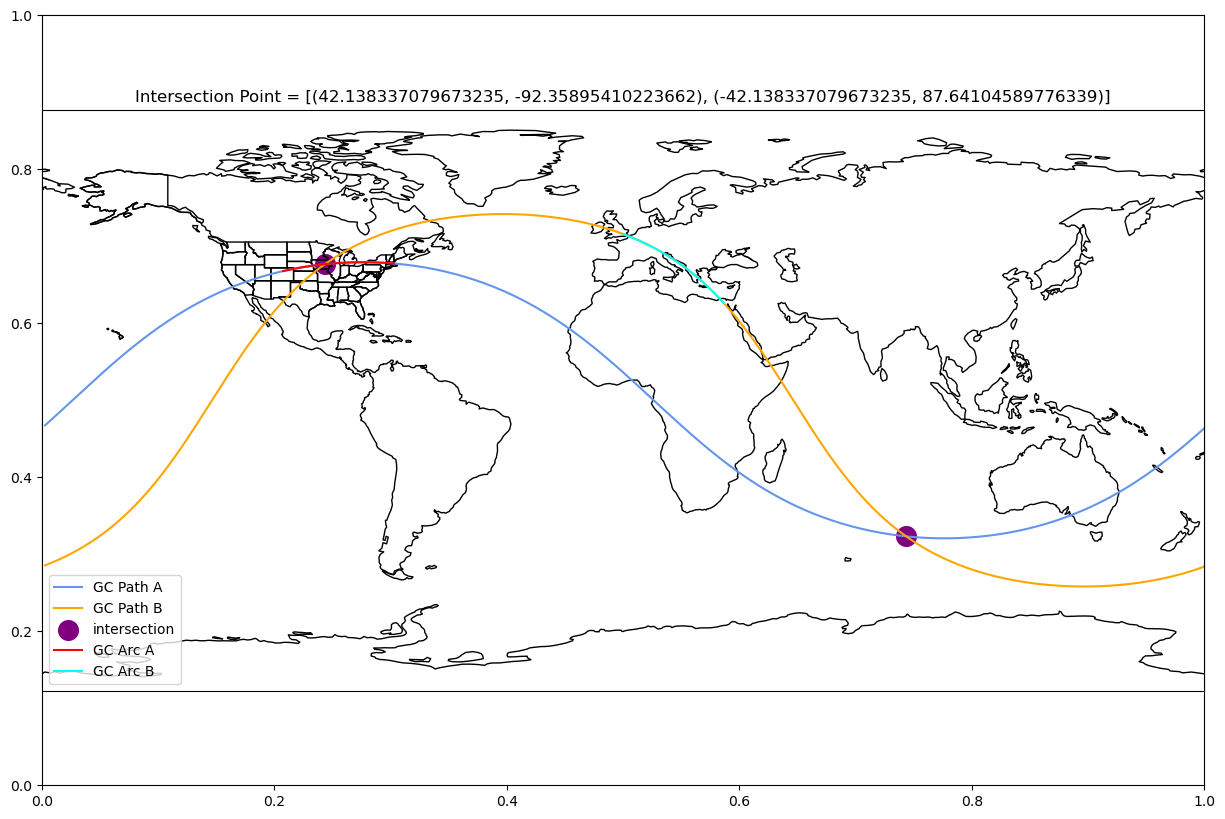

In [16]:
plot_gc_with_intersection("boulder", "boston", "greenwich", "cairo")

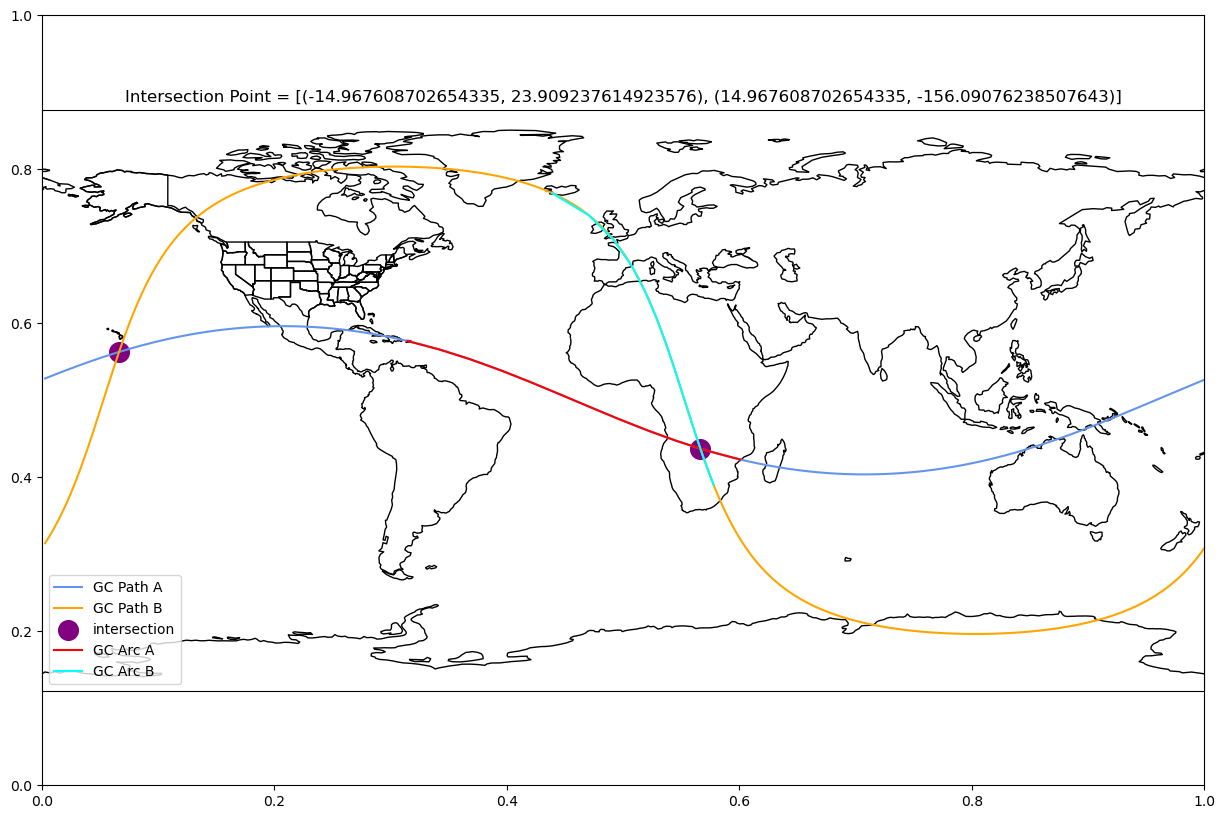

In [17]:
plot_gc_with_intersection("arecibo", "zambezi", "johannesburg", "reykjavík")

---

## Summary

In this notebook, we determined the position where two great circle paths interact on the globe.

### What's next?

Next, we will calculate the internal angles associated with multiple great circles.

## Resources and references

- [Aviation Formulary V1.47](https://edwilliams.org/avform147.htm)
- [Moveable Type Script](https://www.movable-type.co.uk/scripts/latlong.html)